In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2

# Usage demo

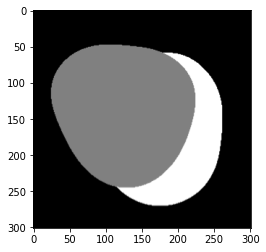

In [3]:
import numpy as np
import cv2


def perlin(x,y,seed=0):
    # permutation table
    #np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def get_curvature(rad):

    rad_t_plus_1  = np.concatenate([rad[1:], rad[:1]], axis=0)
    rad_t_minus_1 = np.concatenate([rad[-1:], rad[:-1]], axis=0)

    drad  = 0.5 * (rad_t_plus_1 - rad_t_minus_1) / (angle[1] - angle[0])
    d2rad = (rad_t_plus_1 - 2 * rad + rad_t_minus_1) / (angle[1] - angle[0]) ** 2

    curvature = np.abs(rad ** 2 + 2 * drad ** 2 - rad * d2rad) / np.sqrt((rad ** 2 + drad ** 2) ** 3)

    return curvature



H = W = 301
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

for i in range(num_imgs):

    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    axis_angle = np.random.rand() * 2 * np.pi

    colors = [255, 128] if np.random.rand() > 0.5 else [128, 255]
    for blob_id, clr in enumerate(colors):
        angle = np.linspace(0.0, 2*np.pi, 10001)[:-1]

        xp = 2.5 + 0.6 * np.cos(angle[np.newaxis, :])
        yp = 2.5 + 0.6 * np.sin(angle[np.newaxis, :])

        p = perlin(xp, yp)

        rad = minrad + (maxrad - minrad) * (0.5 + p)[0, :]

        
        xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
        ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
        curvature = get_curvature(rad)
        for t in range(1000):
            clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
            cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)

In [ ]:
##Attempt at making circles here

C:\Users\Aneel\AppData\Local\Temp/ipykernel_23092/3571504486.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  junctions = np.ones((H, W), dtype=np.bool)


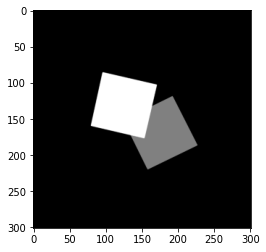

In [80]:
import numpy as np
import cv2

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)





H = W = 201
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

for i in range(num_imgs):
    
    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    #Define 2 centers and 2 rotation_angles
    offset  = np.random.rand(2)
    colors = [128, 255] #if np.random.rand() > 0.5 else [255, 128]
    for blob_id, clr in enumerate(colors):
        theta = np.random.rand()*2*np.pi

        xp = np.asarray([-1,1,1,-1])*H/8.0
        yp = np.asarray([-1,-1,1,1])*H/8.0

        pmat = np.vstack((xp,yp))
        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c, -s), (s, c)))
        
        rotpts = rot@pmat
        
        xlist = H/2 + rotpts[0,:] + offset[0]*np.power(-1,(blob_id == 1))*H/8.0
        ylist = H/2 + rotpts[1,:] + offset[1]*np.power(-1,(blob_id == 1))*H/8.0 

        
#         xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
#         ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
#         curvature = get_curvature(rad)
        for t in range(1000):
#             clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
#             cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)

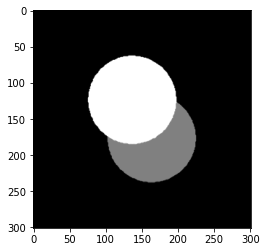

In [7]:
import numpy as np
import cv2

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)





H = W = 301
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

for i in range(num_imgs):
    
    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    #Define 2 centers and 2 rotation_angles
    offset  = np.random.rand(2)
    colors = [128, 255] #if np.random.rand() > 0.5 else [255, 128]
    for blob_id, clr in enumerate(colors):
        theta = np.random.rand()*2*np.pi

        r = np.linspace(0,2*np.pi,200)
        
        xp = np.cos(r)*H/5.0
        yp = np.sin(r)*H/5.0

        pmat = np.vstack((xp,yp))
#         c, s = np.cos(theta), np.sin(theta)
#         rot = np.array(((c, -s), (s, c)))
        
#         rotpts = rot@pmat
        
        xlist = H/2 + pmat[0,:] + offset[0]*np.power(-1,(blob_id == 1))*H/8.0
        ylist = H/2 + pmat[1,:] + offset[1]*np.power(-1,(blob_id == 1))*H/8.0 

        
#         xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
#         ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
#         curvature = get_curvature(rad)
        for t in range(1000):
#             clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
#             cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)

In [60]:
pmat = np.vstack((xp,yp))
pmat.shape

(2, 4)

In [42]:
offset = np.random.rand(1,2)

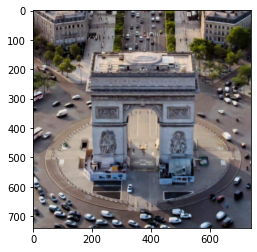

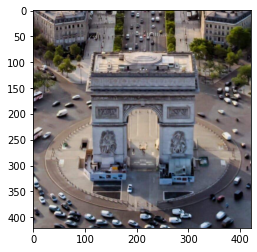

In [3]:
im_big = matplotlib.image.imread('Arch.jpeg')
R = 21
img = cv2.resize(im_big,(400+R,400+R))
plt.imshow(im_big)
plt.figure()
plt.imshow(img)
img.shape
img = np.asarray(img/255.0,dtype=np.float32)

In [45]:
img.shape

(301, 301, 1)

Beginning initialization...
Initialization iteration 0/60
Initialization iteration 5/60
Initialization iteration 10/60
Initialization iteration 15/60
Initialization iteration 20/60
Initialization iteration 25/60
Initialization iteration 30/60
Initialization iteration 35/60
Initialization iteration 40/60
Initialization iteration 45/60
Initialization iteration 50/60
Initialization iteration 55/60
Wall time: 44.2 s


(-0.5, 300.5, 300.5, -0.5)

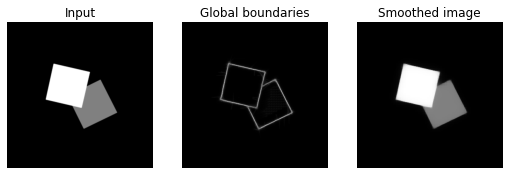

In [81]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 5
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 60
opts.num_refinement_iters     = 0 #Intitialzation only 
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img, cmap='gray')
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Smoothed image')
plt.axis('off')
# plt.subplot(144)
# plt.imshow(clean_img)
# plt.title('Ground truth')
# plt.axis('off');

(301, 301, 1)

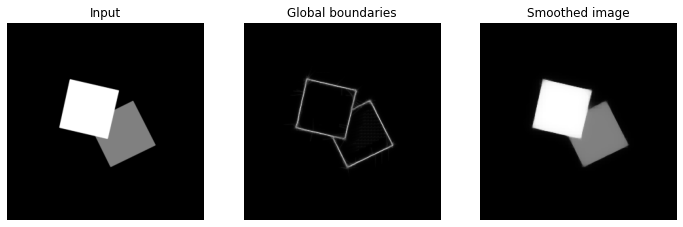

In [82]:
plt.figure(figsize=[12, 12])
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Input')
plt.axis('off')
plt.subplot(132)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(133)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Smoothed image')
plt.axis('off')
plt.show()

In [13]:
xlist

array([260.3136669 , 260.31806437, 260.3224548 , ..., 260.30043239,
       260.30485089, 260.3092624 ])

# Field of junctions visualization demo

## First, visualize all `RxR` input patches

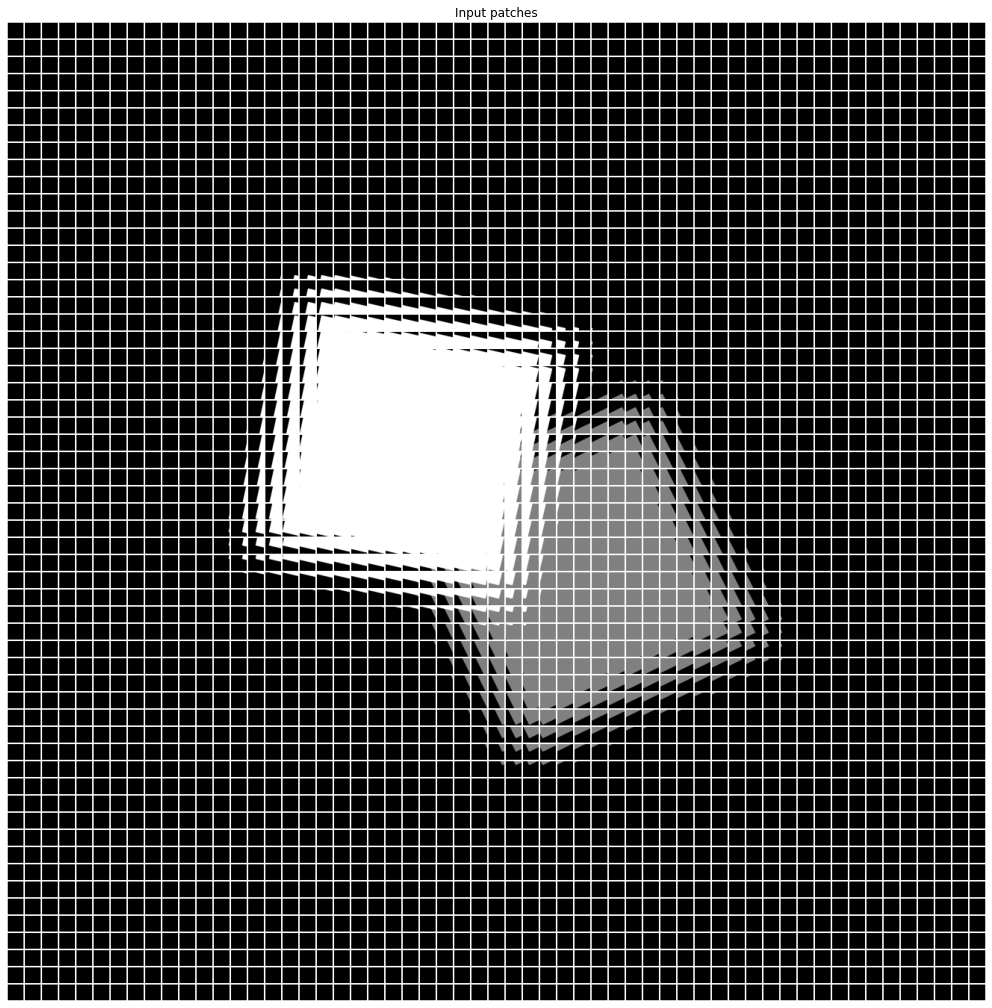

In [83]:
from utils import patchstack

patch_vis = patchstack(foj.img_patches)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(patch_vis,cmap='gray')
plt.title('Input patches')
plt.axis('off');

## Now visualize the local boundary maps obtained by the field of junctions in all patches

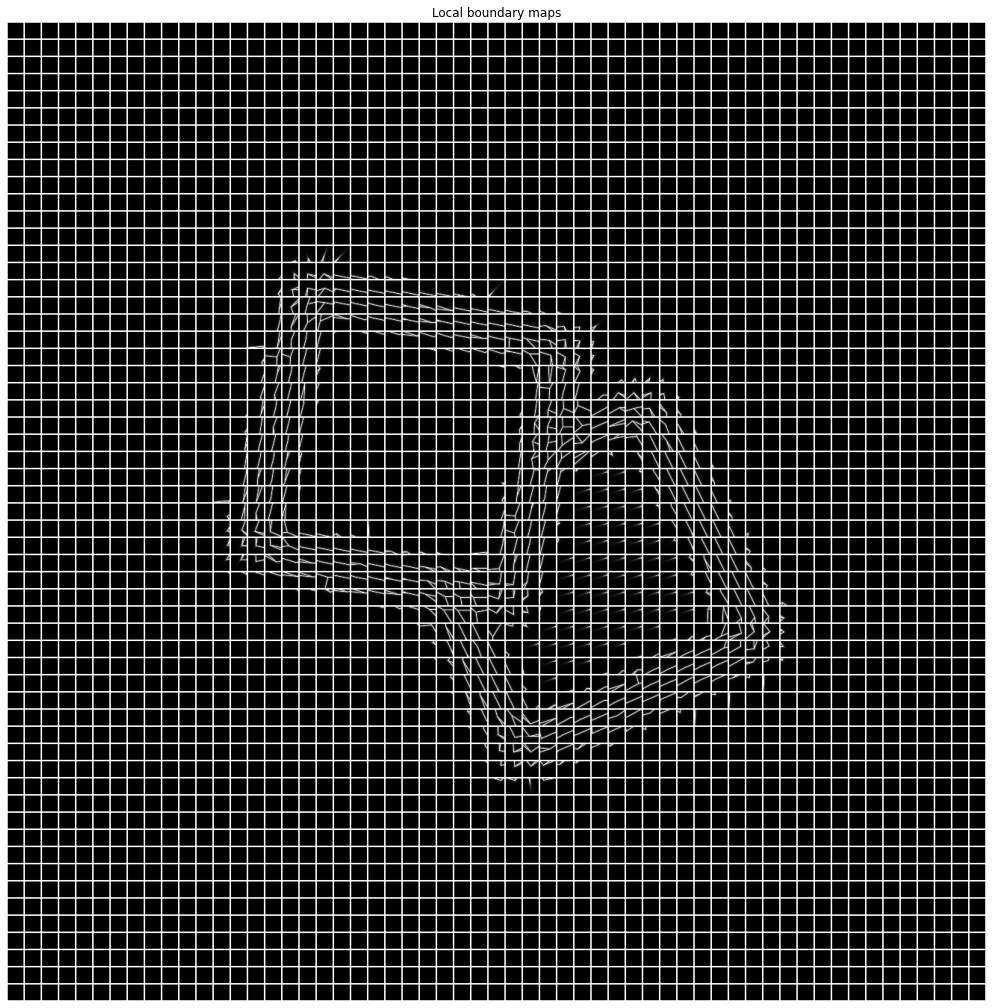

In [84]:
boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');

Text(0.5, 1.0, 'Useful Junctions')

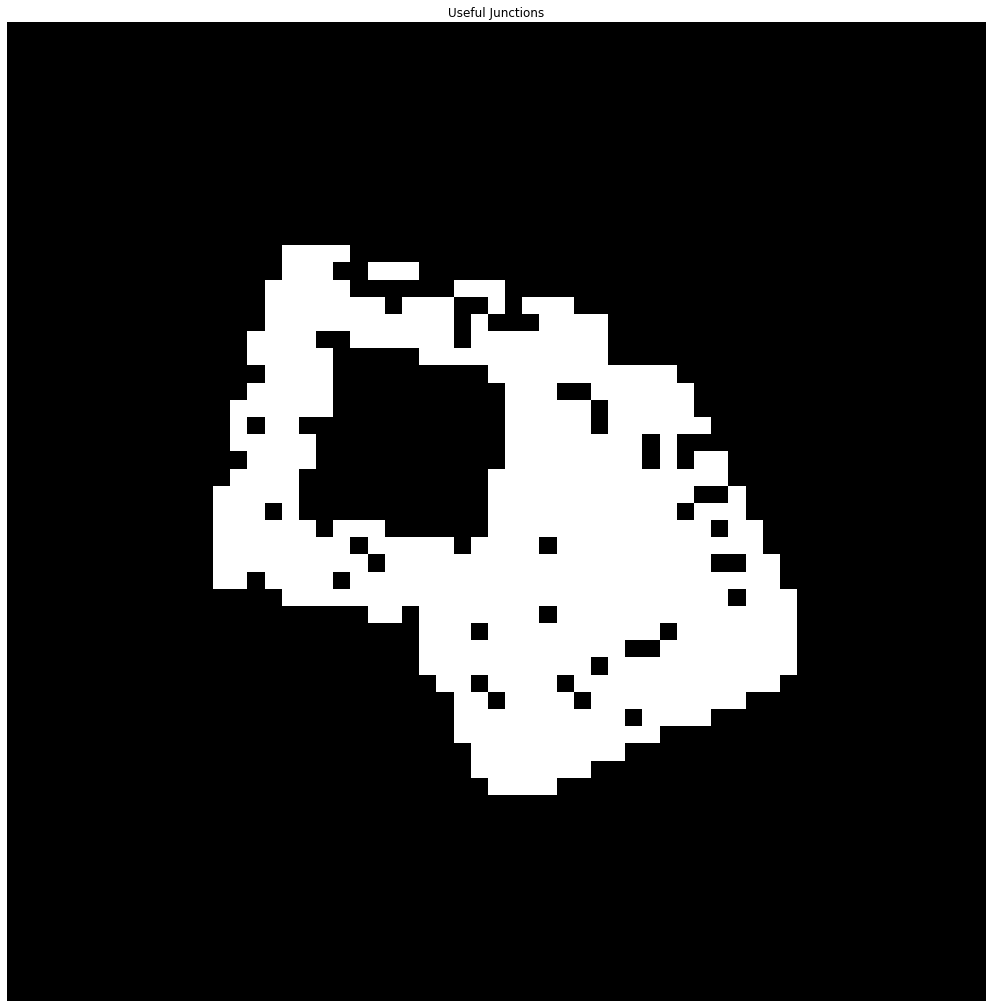

In [85]:
# plt.scatter(foj.x0y0[0,0,...].detach().cpu().numpy().flatten(),foj.x0y0[0,1,...].detach().cpu().numpy().flatten())
# plt.xlim((-150,150))
# plt.ylim((-150,150))
plt.figure(figsize=[18, 18])

vals = np.logical_and(np.abs(foj.x0y0[0,0,...].detach().cpu().numpy()) < (opts.R)*.7/2, 
                        np.abs(foj.x0y0[0,0,...].detach().cpu().numpy()) < opts.R*.7/2)

plt.imshow(vals,cmap='gray')
plt.axis('off')
plt.title("Useful Junctions")

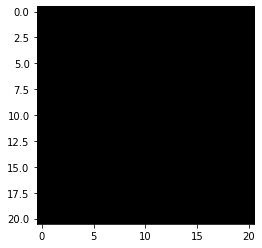

In [17]:
lbs =local_boundaries[0,0, :, :, :].detach().cpu().numpy()
lbs.shape
plt.imshow(lbs[:,:,10,28],cmap='gray',vmin=0,vmax=1)

In [86]:
## Get wedge angles etc.

dists = foj.params2dists(params)    # shape [N, 2, R, R, H', W']

# Get wedge indicator functions
wedges = foj.dists2indicators(dists)
colors = (foj.img_patches.unsqueeze(2) * wedges.unsqueeze(1)).sum(-3).sum(-3) / \
                     (wedges.sum(-3).sum(-3).unsqueeze(1) + 1e-10)


pcolors = colors[0,0,:,...].detach().cpu().numpy()
players = np.round(pcolors*2) 
wedges = foj.dists2indicators(dists).detach().cpu().numpy()


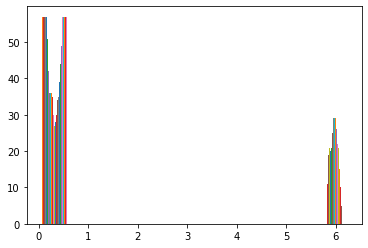

In [87]:
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0]

t_angle1 = angles[0, 0, :, :].detach().cpu().numpy()   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :].detach().cpu().numpy()   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :].detach().cpu().numpy()  # shape [N, 1, 1, H', W']

angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) #ANGLES 3 AND 2 ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE???
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
plt.hist(angle1+angle2+angle3);
anglemat = np.stack((angle1,angle2,angle3),axis = 0)
# plt.subplot(131)
# plt.imshow(angle1)
# plt.colorbar();
# plt.subplot(132)
# plt.imshow(t_angle2)
# plt.colorbar();
# plt.subplot(133)
# plt.imshow(t_angle3)
# plt.colorbar();
# plt.tight_layout();
# plt.show()

0.0
0.0
0.0


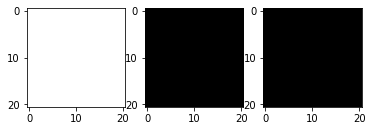

In [88]:
# print(wedges.shape)
# print(local_boundaries.shape)
wedges = foj.dists2indicators(dists).detach().cpu().numpy()
plt.subplot(131)
plt.imshow(wedges[0,0,:,:,-15,37],cmap='gray',vmin=0,vmax=1)
plt.subplot(132)
plt.imshow(wedges[0,1,:,:,-15,37],cmap='gray',vmin=0,vmax=1)
plt.subplot(133)
plt.imshow(wedges[0,2,:,:,-15,37],cmap='gray',vmin=0,vmax=1)
print(angle1[-15,37])
print(angle2[-15,37])
print(angle3[-15,37])

In [89]:
maxangle = np.max(anglemat,axis=0)
medangle = np.median(anglemat,axis=0)
minangle=np.min(anglemat,axis=0)
wedges = foj.dists2indicators(dists)

np.argsort(anglemat,axis=0).shape
players.shape
useful = np.asarray(np.where(vals==1))
useful_angles = anglemat[:,useful[0,:],useful[1,:]]
ang_sort_idx = np.argsort(useful_angles,axis=0)
useful_layers = players[:,useful[0,:],useful[1,:]]

angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
layer_sort_by_angles = np.take_along_axis(useful_layers, ang_sort_idx, axis=0)

# angles_sort_by_layers =  np.take_along_axis(useful_angles, useful_layers, axis=0) # does not work, sometimes same layer on both sides of junction


In [90]:
np.take_along_axis(useful_angles, ang_sort_idx, axis=0)

array([[0.20268321, 0.20268369, 0.        , ..., 0.40536642, 0.        ,
        0.20268297],
       [1.6214676 , 0.40536678, 0.20268333, ..., 1.2161007 , 0.20268345,
        1.8241506 ],
       [4.459035  , 5.675135  , 6.080502  , ..., 4.6617184 , 6.080502  ,
        4.256352  ]], dtype=float32)

In [91]:
vals.shape

(57, 57)

In [92]:
## Only taking those with 3 colors in region
more_useful = []
min_ang_list = []
for patch in range(useful_layers.shape[1]):
    if len(np.unique(useful_layers[:,patch])) == 3:
        #only taking those with large min angle
        min_ang_list.append(angles_ascending[0,patch])
        if angles_ascending[0,patch] > .3:
            more_useful.append(patch)
more_useful = np.asarray(more_useful);
more_useful.shape

(32,)

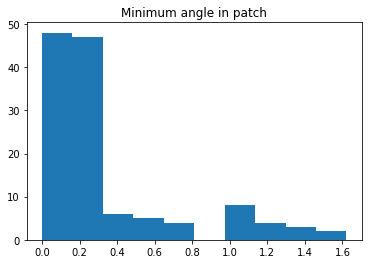

In [93]:
plt.hist(min_ang_list);
plt.title('Minimum angle in patch');

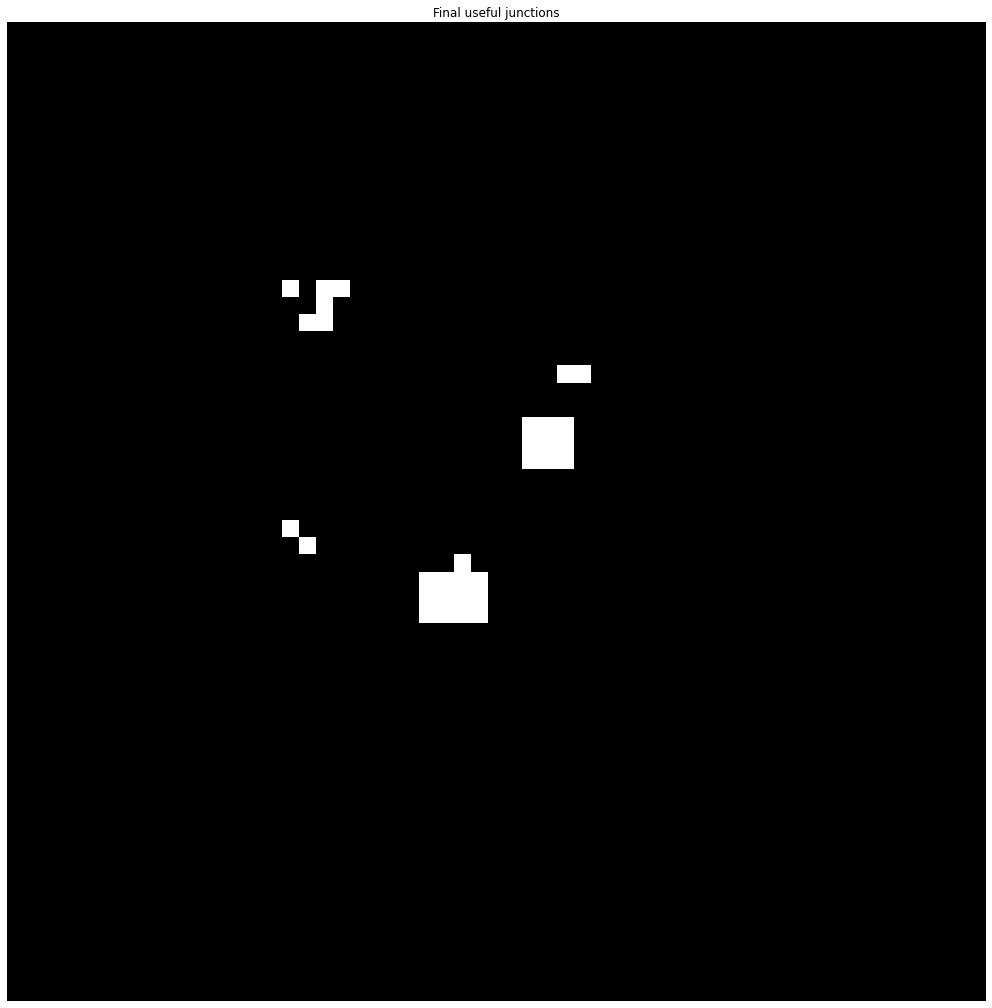

In [94]:
more_useful_idx = useful[:, more_useful]
more_useful_idx.shape

more_useful_mat = np.zeros(vals.shape)
for idx in more_useful:
    more_useful_mat[useful[0,idx],useful[1,idx]] = 1

plt.figure(figsize=(18,18))
plt.imshow(more_useful_mat, cmap='gray')
plt.title('Final useful junctions')
plt.axis('off');

In [95]:
more_useful_angles = anglemat[:,more_useful_idx[0,:],more_useful_idx[1,:]]
ang_sort_idx = np.argsort(more_useful_angles,axis=0)
more_useful_layers = players[:,more_useful_idx[0,:],more_useful_idx[1,:]]

pruned_angles_ascending = np.take_along_axis(more_useful_angles, ang_sort_idx, axis=0)
pruned_layer_sort_by_angles = np.take_along_axis(more_useful_layers, ang_sort_idx, axis=0)

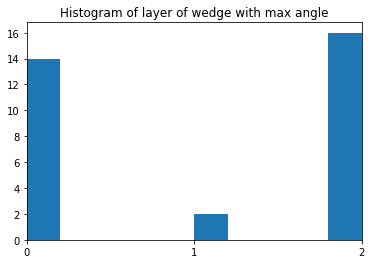

Layer 0 avg max angle:  3.4021854
Layer 2 avg max angle:  3.2049315


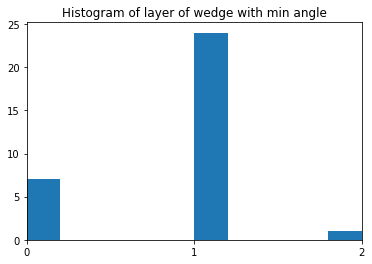

In [96]:
plt.hist(pruned_layer_sort_by_angles[2,:])
plt.title('Histogram of layer of wedge with max angle')
plt.xlim((0,2))
plt.xticks((0,1,2))
plt.show();
#get avg max angle when layer 0 is max

print('Layer 0 avg max angle: ', np.mean(pruned_angles_ascending[2,np.where(pruned_layer_sort_by_angles[2,:] ==0)]))
print('Layer 2 avg max angle: ', np.mean(pruned_angles_ascending[2,np.where(pruned_layer_sort_by_angles[2,:] ==2)]))

plt.figure()
plt.hist(pruned_layer_sort_by_angles[0,:])
plt.title('Histogram of layer of wedge with min angle')
plt.xlim((0,2))
plt.xticks((0,1,2))
plt.show();

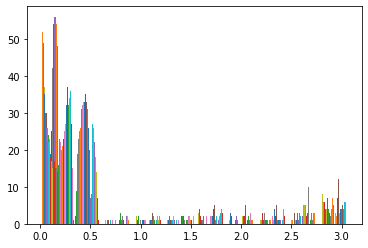

In [197]:
# plt.hist(maxangle);
plt.hist(minangle);
plt.hist(medangle);

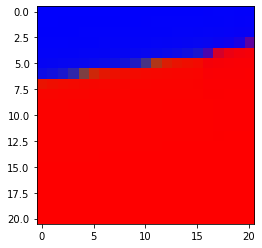

In [67]:
wedges.shape
wedge1 = wedges[0,:,:,:,27,3].detach().cpu().numpy()
wedge1 = np.swapaxes(wedge1,0,-1)
plt.imshow(wedge1)

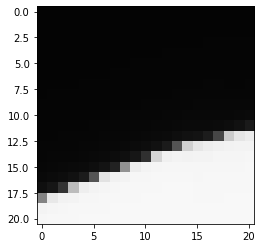

In [363]:
## COlors?


patches = (wedges.unsqueeze(1) * colors.unsqueeze(-3).unsqueeze(-3)).sum(dim=2)
patches.shape
plt.imshow(patches.detach().cpu().numpy()[0,0,:,:,10,20],cmap='gray',vmin=0,vmax=1)

In [270]:
players[:,10,28]
pcolors[:,10,28]

array([0.53565824, 0.04271748, 0.9749233 ], dtype=float32)

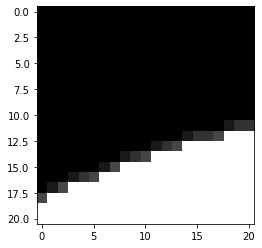

In [362]:
plt.imshow(foj.img_patches.detach().cpu().numpy()[0,0,:,:,10,20],cmap='gray',vmin=0,vmax=1)

# Optimization visualization demo

In [6]:
# Using the exposed foj.step() function it is possible to create a visualization of the entire optimization
# process (here using the imageio package, but you can also use OpenCV's VideoWriter for example)
opts = SimpleNamespace()

opts.R                        = R
opts.stride                   = 10
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.004
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.6
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 40
opts.num_refinement_iters     = 2000
opts.greedy_step_every_iters  = 30
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


import imageio

def foj_optimize_visualize_optimization():
    with imageio.get_writer('ArchBoundaries_R21_2000iters.mp4', fps=60, quality=9) as writer:
        for i in range(foj.num_iters):
            if i == 0:
                print("Beginning initialization...")
            if i == opts.num_initialization_iters:
                print("Initialization done. Beginning refinement...")
            if i < opts.num_initialization_iters:
                if i % 5 == 0:
                    print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
            else:
                if i % 100 == 0:
                    print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
            foj.step(i)
            
            # Compute smoothed image and boundaries
#             params = torch.cat([foj.angles, foj.x0y0], dim=1)
#             dists, _, patches = foj.get_dists_and_patches(params)
#             local_boundaries = foj.dists2boundaries(dists)
#             global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis]
#             smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

            #FOR COLOR IMAGE
            params = torch.cat([foj.angles, foj.x0y0], dim=1)
            dists, _, patches = foj.get_dists_and_patches(params)
            local_boundaries = foj.dists2boundaries(dists)
            global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis].repeat(3, 2)
            smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()
            output = np.concatenate([img, smoothed_img, global_boundaries], axis=1)
                        
            writer.append_data(np.uint8(255.0 * output))
    return img, smoothed_img, global_boundaries

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
i1,i2,i3 = foj_optimize_visualize_optimization()



Beginning initialization...
Initialization iteration 0/40


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1263, 421) to (1264, 432) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Initialization iteration 5/40
Initialization iteration 10/40
Initialization iteration 15/40
Initialization iteration 20/40
Initialization iteration 25/40
Initialization iteration 30/40
Initialization iteration 35/40
Initialization done. Beginning refinement...
Refinement iteration 100/2000
Refinement iteration 200/2000
Refinement iteration 300/2000
Refinement iteration 400/2000
Refinement iteration 500/2000
Refinement iteration 600/2000
Refinement iteration 700/2000
Refinement iteration 800/2000
Refinement iteration 900/2000
Refinement iteration 1000/2000
Refinement iteration 1100/2000
Refinement iteration 1200/2000
Refinement iteration 1300/2000
Refinement iteration 1400/2000
Refinement iteration 1500/2000
Refinement iteration 1600/2000
Refinement iteration 1700/2000
Refinement iteration 1800/2000
Refinement iteration 1900/2000
Refinement iteration 2000/2000


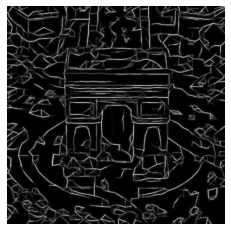

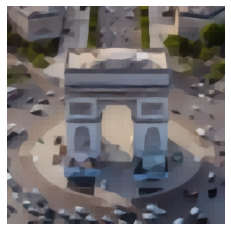

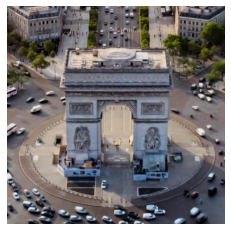

In [12]:
plt.imshow(i3)
plt.axis('off')

plt.savefig('ArcBoundaries.png')
plt.figure()
plt.imshow(i2)
plt.axis('off')
plt.savefig('ArcSmoothImages.png')
plt.figure()
plt.imshow(i1)
plt.axis('off')
plt.savefig('ArcImage.png')